In [5]:
import sys
sys.path.insert(0, '/home/toepfer/Documents/Project_PhysNet3/KaiAsparagus')

# Asparagus Tutorial - Introduction into Sampling Methods
This tutorial introduces basic sampling methods implemented in the Asparagus Bundle package.
The aim is to show the basic input arguments for the main sampler class and the methods in particular.
All examples shown here are applied to the molecule ammonia NH$_3$, but the experience gained for such simple system also applies to more complex ones. 

The main class Sampler with its general input arguments is presented first, followed in this order by the methods for molecular dynamics sampling (MDSampler), meta dynamics sampling (MetaSampler) and the classes Normal Mode Scanner (NMScanner) and Sampler (NMSampler). As a reference method for the system properties energy, forces and dipole, the tight-binding density functional method "GFNn-xTB" is used, which is executed by the XTb program and its respective calculator of the package "Atomic Simulation Environment" (ASE).

## Main Sampler Class
 
Sampler is the parent class for all sampling methods and the functionality of its input also applies to all other sampling methods, unless otherwise specified. The first example shows the initialization of a sampler instance, where a NH$_3$ system, ammonia, in $C_{3v}$ symmetry is loaded (```sample_systems='ref/nh3_c3v. xyz'```), system properties are calculated with XTb (```sample_calculator='xtb'```) and the result is saved in an Asparagus database file ```nh3.db``` (```sample_data_file='nh3.db'```). The defined tasks are executed by the ```.run()``` command.

In [10]:
from asparagus.sample import Sampler
sampler = Sampler(
    config='nh3.json',
    sample_data_file='nh3.db',
    sample_systems='ref/nh3_c3v.xyz',
    sample_calculator='XTB')
sampler.run()

INFO:asparagus.settings.config:INFO:
Configuration file path set to 'nh3.json'!

INFO:asparagus.settings.config:INFO:
Parameter update in 'nh3.json'
  (overwrite conflicts)
Adding parameter 'sampler_schedule'.
Adding parameter 'sample_counter'.
2 new parameter, 2 added, 0 equal, 0 overwritten

INFO:asparagus.sample.sampler:INFO:
Perform sampling method 'sample' on systems:
   1. 'ref/nh3_c3v.xyz'

INFO:asparagus.sample.sampler:INFO:
Sampling method 'sample' complete for system from 'ref/nh3_c3v.xyz!'
1 sample written to 'nh3.db'.



Not mentioned so far is the keyword argument ``config``, which can be either a dictionary of the presented keyword arguments or a file path to a ```.json``` file (```config='nh3.json'```) where a copy of the input files is stored or input arguments are read from. When the code is executed for the first time, a json file with the content is written:
```
{
  "config_file": "nh3.json",
  "sampler_schedule": {
    "1_sample": {
      "sample_data_file": "nh3.db",
      "sample_directory": ".",
      "sample_systems": "ref/nh3_c3v.xyz",
      "sample_calculator": "XTB",
      "sample_calculator_args": {},
      "sample_properties": [
        "energy",
        "forces",
        "dipole"
      ],
      "sample_systems_optimize": false,
      "sample_systems_optimize_fmax": 0.001,
      "sample_data_overwrite": false
    }
  },
  "sample_counter": 1
}
```

The file stores further default arguments, most of which are contained in the entries ```sampler_schedule``` and ```1_sample```, where the integer is the sequence number of the selected sampling method and the following tag is method-dependent. If the code is executed multiple times, new entries are added to the json file (```2_sample```, ```3_sample``` etc.) and the ```sample_counter``` is updated. 

Important could be the argument ```input_properties```, which defines the system properties that are written to the database file, but must also be supported by the reference calculator. If not, an error message will be displayed. The argument ```sample_systems_optimize``` could be set to ```True``` in the input code, which would have ordered a structure optimization down to a atomic force limit below $0.001$ eV (```"sample_systems_optimize_fmax": 0.001```). Only the optimized structure would be stored in the database file. This function becomes more useful in later sampling methods such as the NormalModeSampler.

The sampler class can also be used to calculate an ensemble of structures, e.g. from an ASE trajectory file (```sample_data_file='ref/nh3.traj'```) with the reference calculator and save the results in the database file. Even if in this case the format of the system file is taken from the suffix of the file name, in some cases it may be useful to define the format of the system file manually (```sample_data_file_format='traj'```).

In [11]:
sampler = Sampler(
    config='nh3.json',
    sample_data_file='nh3.db',
    sample_systems='ref/nh3.traj',
    sample_systems_format='traj',
    sample_calculator='XTB',
    sample_calculator_args = {
        'directory': 'calc'},
    sample_properties=['energy', 'forces', 'dipole'],
    sample_num_threads=4,
    )
sampler.run()

INFO:asparagus.settings.config:INFO:
Parameter update in 'nh3.json'
  (overwrite conflicts)
Overwrite parameter 'sampler_schedule'.
Overwrite parameter 'sample_counter'.
2 new parameter, 0 added, 0 equal, 2 overwritten

INFO:asparagus.sample.sampler:INFO:
Perform sampling method 'sample' on systems:
   1. 'ref/nh3.traj'

INFO:asparagus.sample.sampler:INFO:
Sampling method 'sample' complete for system from 'ref/nh3.traj!'
6 samples written to 'nh3.db'.

INFO:asparagus.sample.sampler:INFO:
Sampling method 'sample' complete for system from 'ref/nh3.traj!'
2 samples written to 'nh3.db'.

INFO:asparagus.sample.sampler:INFO:
Sampling method 'sample' complete for system from 'ref/nh3.traj!'
1 sample written to 'nh3.db'.

INFO:asparagus.sample.sampler:INFO:
Sampling method 'sample' complete for system from 'ref/nh3.traj!'
2 samples written to 'nh3.db'.



Here you may have noticed that the sample calculation is split into 4 parallel threads (```sample_num_threads=4```), which is not useful for such fast reference methods as XTb, but can be useful when using high-level methods on computer clusters through user-defined ```shell``` or ```slurm``` sample calculator (see later tutorials).

Let's take a quick look at the systems written to the database file and their calculated energies.

In [16]:
import asparagus
# Initialize Asparagus main class and read arguments from the json file
asp = asparagus.Asparagus(
    config='nh3.json',
    data_file='nh3.db',
)
# Get the main Asparagus datacontainer object reading the database file 'nh3.db'
data = asp.get_data_container()

# Iterate over the database entries and show the energies
for idx, datai in enumerate(data):
    print(f"Database entry number {idx + 1:>2d} with atomic numbers {datai['atomic_numbers']} has energy {datai['energy']:4.3f} eV")


INFO:asparagus.settings.config:INFO:
Parameter update in 'nh3.json'
  (called from 'Asparagus Main')
  (overwrite conflicts)
1 new parameter, 0 added, 1 equal, 0 overwritten

INFO:asparagus.settings.config:INFO:
Empty update configuration dictionary!

INFO:asparagus.settings.config:INFO:
Parameter update in 'nh3.json'
  (overwrite conflicts)
2 new parameter, 0 added, 2 equal, 0 overwritten

INFO:asparagus.settings.config:INFO:
Empty update configuration dictionary!

INFO:asparagus.settings.config:INFO:
Parameter update in 'nh3.json'
  (called from 'DataContainer 'nh3.db'')
  (overwrite conflicts)
16 new parameter, 0 added, 16 equal, 0 overwritten

INFO:asparagus.data.datacontainer:INFO:
12 reference data points are distributed on data subsets.
Training data:        9 ( 75.0%)
Validation data:      1 ( 8.3%)
Test data:            2 ( 16.7%)




       '   _______                                                  ______                  _ _        
       '  (_______)                                                (____  \                | | |       
       '   _______  ___ ____  _____  ____ _____  ____ _   _  ___    ____)  )_   _ ____   __| | | _____ 
       '  |  ___  |/___)  _ \(____ |/ ___|____ |/ _  | | | |/___)  |  __  (| | | |  _ \ / _  | || ___ |
       '  | |   | |___ | |_| / ___ | |   / ___ ( (_| | |_| |___ |  | |__)  ) |_| | | | ( (_| | || ____|
       '  |_|   |_(___/|  __/\_____|_|   \_____|\___ |____/(___/   |______/|____/|_| |_|\____|\_)_____)
       '               |_|                     (_____|                            
       '
       '                        Authors: K. Toepfer and L.I. Vazquez-Salazar
       '                        Date: 2024-03-26 16:15:59
       '                        Running on: pc-debussy
       '                        Details of this run are stored in: nh3.json 
       ' -------

## Molecular Dynamics Sampler Class

The Asparagus implementation of molecular dynamics (MD) samplings performs a $NVT$-Langevin dynamics run of a sample system using the ```ase.md.langevin.Langevin``` class of ASE (https://wiki.fysik.dtu.dk/ase/ase/md.html#module-ase.md.langevin). Specific input arguments are the target temperature ```md_temperature``` (default 300 K) and the Langevin friction coefficient ```md_langevin_friction``` (default 0.01 K) as well as the total run time ```md_simulation time``` and the time step ```md_time_step``` both in femto-seconds. The input argument ```md_save_interval``` defines the step number interval in which the current frame with its system properties is written to the database file. Before MD sampling, an equilibration MD run can be excuted and defined by ```md_equilibration_time``` (default is no equilibration run, 0 fs) or initial velocities with respect to Maxwell-Boltzmann distribution can be assigned to a corresponding temperature ```md_initial_temperature``` (default is no velocities, 0 K). In the next example, the ammonia molecule is optimized before the MD simulation of 100 fs with 1 fs time steps is started.

In [17]:
from asparagus.sample import MDSampler
sampler = MDSampler(
    config='nh3.json',
    sample_directory='mdsampling',
    sample_data_file='mdsampling/md_nh3.db',
    sample_systems='ref/nh3_c3v.xyz',
    sample_systems_format='xyz',
    sample_calculator='xtb',   # Not thread save when using ASE modules
    sample_num_threads=1,
    sample_systems_optimize=True,
    sample_systems_optimize_fmax=0.001,
    md_temperature=300,
    md_langevin_friction=0.01,
    md_time_step=1.0,
    md_simulation_time=100.0,
    md_save_interval=10)
sampler.run()

INFO:asparagus.settings.config:INFO:
Parameter update in 'nh3.json'
  (overwrite conflicts)
Overwrite parameter 'sampler_schedule'.
Overwrite parameter 'sample_counter'.
2 new parameter, 0 added, 0 equal, 2 overwritten

INFO:asparagus.sample.sampler:INFO:
Perform sampling method 'md' on systems:
   1. 'ref/nh3_c3v.xyz'

INFO:asparagus.sample.md:INFO:
Sampling method 'md' complete for system of index 0 from 'ref/nh3_c3v.xyz!'
11 samples written to 'mdsampling/md_nh3.db'.



Here, the generated sampling files, such as an ASE trajectory file of the MD simulation, are written to the sampling directory ```Sample_directory='mdsampling'```. The sampling arguments are saved in the json file in the ```sampler_schedule``` entry under ```3_md``` (the number of running samples may vary).

## Meta Dynamics Sampler Class

Meta dynamics sampling uses a simple algorithm in which Gaussian-like penalty potentials of height ```meta_gaussian_height``` and width ```meta_gaussian_width``` are added to the effective potential at the location of the collective variables (cv) at certtain frames in the simulation. A cv can be defined either as bond distance (```meta_cv=[[0, 1]]```), bond angle (```meta_cv=[[0, 1, 2]]```), dihedral angle (```meta_cv=[[0, 1, 2, 3]]```, not yet implemented), reactive coordinate (```meta_cv=[['-', 0, 1, 2, 3]]``` as $d_\mathrm{cv} = d(0,1) - d(2,3)$) between atoms or as a set of them (e.g. ```meta_cv=[[0, 1], [0, 2], [0, 3]]``` for all three N-H bonds). The meta dynamic scheme is treated as an ASE constraint in an $NVT$ Langevin dynamics. Depending on the height, width and set interval (```meta_save_interval``) of the Gaussian potential options, a larger Langevin friction coefficient may be necessary to prevent 'overheating' (exploding temperature) of the system during the dynamics.

In the following example, one N-H bond is defined as a cv and a simulation of 1 ps (= 1000 fs) is performed, setting the Gaussian potential every 10 steps.

In [29]:
from asparagus.sample import MetaSampler
sampler = MetaSampler(
    config='nh3.json',
    sample_directory='metasampling',
    sample_data_file='metasampling/meta_nh3.db',
    sample_systems='ref/nh3_c3v.xyz',
    sample_systems_format='xyz',
    sample_calculator='XTB',   # Not thread save when using ASE modules
    sample_num_threads=1,
    sample_systems_optimize=True,
    sample_systems_optimize_fmax=0.001,
    meta_cv=[[0, 1]],
    meta_gaussian_height=0.15,
    meta_gaussian_widths=0.1,
    meta_gaussian_interval=10,
    meta_hookean=[[0, 1, 2.0]],
    meta_temperature=500,
    meta_time_step=1.0,
    meta_simulation_time=1000.0,
    meta_save_interval=5,
    )
sampler.run()

INFO:asparagus.settings.config:INFO:
Parameter update in 'nh3.json'
  (overwrite conflicts)
Overwrite parameter 'sampler_schedule'.
Overwrite parameter 'sample_counter'.
2 new parameter, 0 added, 0 equal, 2 overwritten

INFO:asparagus.sample.sampler:INFO:
Perform sampling method 'meta' on systems:
   1. 'ref/nh3_c3v.xyz'

INFO:asparagus.sample.meta:INFO:
Sampling method 'meta' complete for system of index 0 from 'ref/nh3_c3v.xyz!'
201 samples written to 'metasampling/meta_nh3.db'.



You may have noticed the input argument ```meta_hookean=[[0, 1, 4.0]]``` which applies an ASE hookean constraint between nitrogen atom ($0$) and hydrogen atom ($1$), which imposes a harmonic constraint of force constant $k=5.0\,$eV/Ang$^2$ (default) starting at a N-H bond distance of 2 Ang and higher ($V_\mathrm{hookean} = [5.0 \cdot (d(0,1) - 2.0)^2]\,$eV if $d(0,1) > 2.0$ Ang else $V_\mathrm{hookean}=0$). This restriction is intended to prevent the bond dissociation with distances larger than a threshold distance. It could lead to numerically or even physically incorrect results from the reference method or just narrows down the range of sampled conformations.

The meta dynamic run is written every 5 steps (```meta_save_interval=5```) to a trajectory file in the sample directory ```metasampling``` and to the database file ```metasampling/meta_nh3.db```. Using the trajectory file or the database, we can plot the time sequence of the N-H bond distance, defined as cv, and see the area sampled by meta dynamic sampler increases as the simulation time progresses.

INFO:asparagus.settings.config:INFO:
Parameter update in 'nh3.json'
  (called from 'Asparagus Main')
  (overwrite conflicts)
1 new parameter, 0 added, 1 equal, 0 overwritten

INFO:asparagus.settings.config:INFO:
Empty update configuration dictionary!

INFO:asparagus.settings.config:INFO:
Parameter update in 'nh3.json'
  (overwrite conflicts)
2 new parameter, 0 added, 2 equal, 0 overwritten

INFO:asparagus.settings.config:INFO:
Empty update configuration dictionary!

INFO:asparagus.settings.config:INFO:
Parameter update in 'nh3.json'
  (called from 'DataContainer 'metasampling/meta_nh3.db'')
  (overwrite conflicts)
16 new parameter, 0 added, 16 equal, 0 overwritten

INFO:asparagus.data.datacontainer:INFO:
201 reference data points are distributed on data subsets.
Training data:      160 ( 79.6%)
Validation data:     20 ( 10.0%)
Test data:           21 ( 10.4%)




       '   _______                                                  ______                  _ _        
       '  (_______)                                                (____  \                | | |       
       '   _______  ___ ____  _____  ____ _____  ____ _   _  ___    ____)  )_   _ ____   __| | | _____ 
       '  |  ___  |/___)  _ \(____ |/ ___|____ |/ _  | | | |/___)  |  __  (| | | |  _ \ / _  | || ___ |
       '  | |   | |___ | |_| / ___ | |   / ___ ( (_| | |_| |___ |  | |__)  ) |_| | | | ( (_| | || ____|
       '  |_|   |_(___/|  __/\_____|_|   \_____|\___ |____/(___/   |______/|____/|_| |_|\____|\_)_____)
       '               |_|                     (_____|                            
       '
       '                        Authors: K. Toepfer and L.I. Vazquez-Salazar
       '                        Date: 2024-03-26 17:52:59
       '                        Running on: pc-debussy
       '                        Details of this run are stored in: nh3.json 
       ' -------

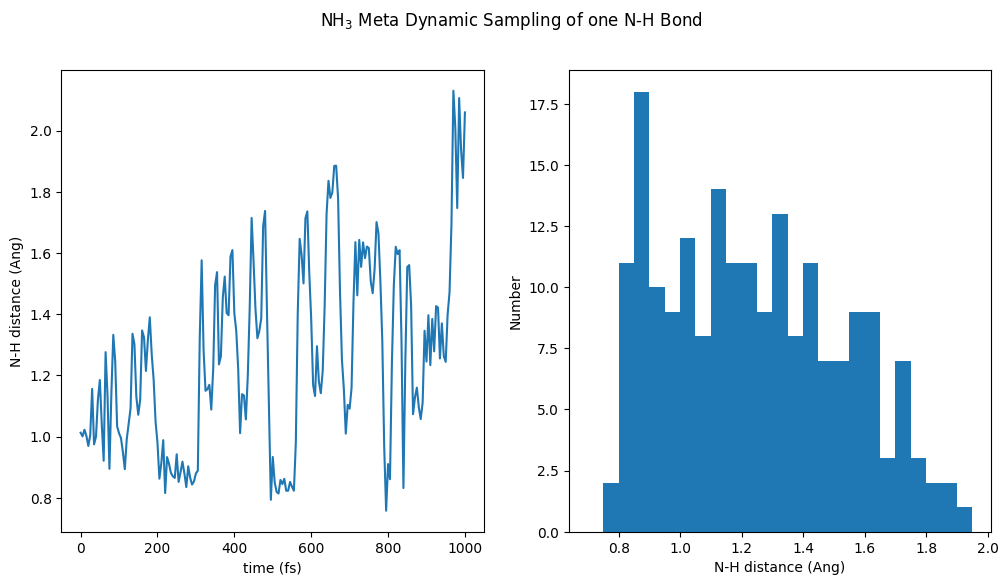

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize Asparagus main class
asp = asparagus.Asparagus(
    config='nh3.json',
    data_file='metasampling/meta_nh3.db',
)
# Get the main Asparagus datacontainer object
data = asp.get_data_container()

# Iterate over the database entries and compute the N-H bond distance
time = np.arange(0, len(data))*5
distance = np.zeros(len(data))
for idx, datai in enumerate(data):
    position_n = datai['positions'][0]
    position_h = datai['positions'][1]
    distance[idx] = np.linalg.norm(position_n - position_h)

# Plot distance time sequence and histogram
fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(12, 6))
axs1.plot(time, distance)
axs1.set_xlabel("time (fs)")
axs1.set_ylabel("N-H distance (Ang)")
axs2.hist(distance, bins=np.arange(0.7,2.0,0.05))
axs2.set_xlabel("N-H distance (Ang)")
axs2.set_ylabel("Number")

plt.suptitle("NH$_3$ Meta Dynamic Sampling of one N-H Bond")
plt.show()

## Normal Mode Scanner

Normal mode scanning is a sampling algorithm that applies scaled vibrational normal mode vectors $\boldsymbol{Q_\nu} = \{
\boldsymbol{q}_i \}$ on the initial position of the sample system of which the harmonic frequencies $\{\nu_i\}$ and normal modes are computed. The algorithm iterates over a specified selection of normal modes (or combination of normal modes, see argument ```nms_number_of_coupling```) and apply a normal mode vector (or combination of normal mode vectors) scaled by negative and positive multiples $n$ of a frequency dependent scaling factor $f_i$. The amplitude of the scan steps along the normal modes are defined in form of an energy step size $\Delta E_\mathrm{step}$. The scaling factor $f_i$ for the respective normal mode $\boldsymbol{q}_i$ will be set to the value that the first elongation yield an energy deviation $ \Delta E_{i,1} = | E(\boldsymbol{x}_\mathrm{init} + 1 f_i \boldsymbol{q}_i) - E(\boldsymbol{x}_\mathrm{init}) | \equiv \Delta E_\mathrm{step}$ within the harmonic approximation.

The figure above show the idea of normal mode scanning on the example of N$_2$ with its bond elongation potential shown as solid black line.
The orange potential curve is the harmonic potential with the harmonic frequency from the reference calculation of $2439$ cm$^{-1}$. The scan step size is set to $0.25$ eV which correlates to a N-N bond elongation of about $\pm 0.07$ Ang within the harmonic approximation. Increasing the N-N equilibrium bond distance by $+0.07$ Ang the reference calculation yield a larger potential change of $+0.28$ eV. Harmonically, with each additional step the potential is supossed to increase by $\Delta E_{i,n} = n^2 \cdot 0.25$ eV ($1^2 \cdot 0.25$,$2^2 \cdot 0.25 = 1.00$, $3^2 \cdot 0.25 = 2.25$ eV) but the real potential change is smaller due to anharmonicity.

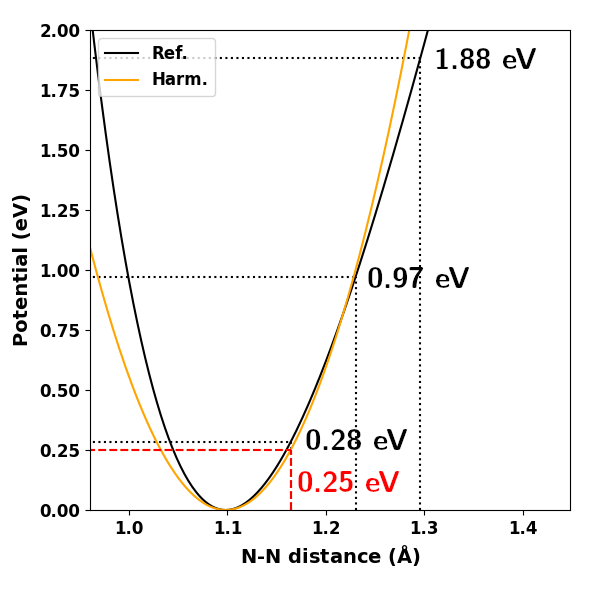

In [1]:
from IPython.display import Image
Image("ref/nms_theory.png")

The following normal mode scan of the ammonia system, requests an initial structure optimization ```sample_systems_optimize=True``` followed by the required normal mode scan. It wu

In [ ]:
sampler = NormalModeScanner(
    config='nh3_nms.json',
    sample_data_file='nh3_nms.db',
    sample_systems='nh3_c3v.xyz',
    sample_systems_format='xyz',
    sample_calculator='XTB',   # Not thread save when using ASE modules
    sample_num_threads=1,
    sample_systems_optimize=True,
    sample_systems_optimize_fmax=0.001,
    sample_save_trajectory=True,
    nms_harmonic_energy_step=0.05,
    nms_energy_limits=1.00,
    nms_number_of_coupling=2,
    )

The scaling factor $f_i$ is
determined by a user-defined energy step input $E_\mathrm{step}$,
that is supposed to yield within the harmonic approximation the energy
difference
\begin{equation}
    E_\mathrm{step} = \Delta E_{i,n=\pm1} = |
    E_\mathrm{harm}(\boldsymbol{x}_\mathrm{init} \pm f_i
    \boldsymbol{q}_i) - E(\boldsymbol{x}_\mathrm{init}) |
\end{equation}
between the initial energy $E(\boldsymbol{x}_\mathrm{init})$ and the
energy when the respectively scaled normal mode vector is applied once
$E(\boldsymbol{x}_\mathrm{init} \pm f_i \boldsymbol{q}_i)$. Positive
and negative multiples of the scaled normal mode vector ($n f_i
\boldsymbol{q}_i$ with $n \subset \mathbb{Z}$) are applied until the
absolute energy difference $\Delta E_{\nu,n}$
\begin{equation}
    \Delta E_{i,n} = | E(\boldsymbol{x}_\mathrm{init} + n f_i
    \boldsymbol{q}_i) - E(\boldsymbol{x}_\mathrm{init}) |
\end{equation}
exceeds an user-defined energy limit $E_\mathrm{limit}$ or the
absolute value of the multiplier $|n|$ reached a user-defined step
limit $n_\mathrm{max}$.  \\

\noindent
The normal mode scaling factor $f_i$ for each frequency $\nu_i$ depend
on their respective force constant $k_i$
\begin{equation}
    k_i = 4\pi^2 (c\nu_i)^2/\mu_i
\end{equation}
where $c$ is the speed of light and $\mu_i$ is the reduced mass of the
respective normal mode
\begin{equation}
  \mu_i = \left[ \sum_j^{N_\mathrm{atoms}} \left( \boldsymbol{q}_i
    \cdot \boldsymbol{q}_i \right) / m_j \right]^{-1}
\end{equation}
with $m_j$ as atom mass of atom $j$. The normal modes are each
normalized by $\boldsymbol{q}_i = \boldsymbol{q'}_i / \left| \left|
\boldsymbol{q'}_i \right| \right|$ with $\boldsymbol{q'}_i$ as the
normal mode vector from the harmonic vibrational analysis.  According
to the harmonic approximation for the potential along the scaled
normal mode vector $f_i \boldsymbol{q}_i$ with
\begin{equation}
    E_i(f) = 0.5 k_i \cdot \left| \left| f \boldsymbol{q}_i \right|
    \right|^2 = 0.5 k_i \cdot f^2 ~~~,
\end{equation}
the respective scaling factor $f_i$ to yield $E_\mathrm{step}$ is
\begin{equation}
    f_i = \sqrt{\dfrac{2 E_\mathrm{step}}{k_i}}.
\end{equation}

\noindent
It is important to mention that the real initial energy difference
($n=\pm1$) will not yield the defined energy step value
$E_\mathrm{step}$ due to the anharmonicity of the PES and do also not
propagate by $\propto n^2$. Depending on the molecular system and
vibrational mode, the real energy steps can both propagate less
strongly (e.g. bond dissociation of a diatomic molecule) or more
strongly (e.g. bending modes of larger molecules).  The initial
conformation $\boldsymbol{x}_\mathrm{init}$ on which the harmonic
normal mode analysis is applied and does not necessarily have to be an
equilibrium state. Even for one (transition state) or multiple
imaginary frequencies, the algorithm handles the normal modes as usual
until the energy difference $\Delta E_{i,n}$, defined as absolute
value, reaches the energy limit or step limit.  \\

\noindent
As mentioned, normal mode scanning can applied for a combination
$\boldsymbol{C}$ of a number multiple normal modes $N_C$, that yields
an expression for the energy difference
\begin{equation}
    \Delta E_{\boldsymbol{C},\boldsymbol{n}} = |
    E(\boldsymbol{x}_\mathrm{init} + \sum_{i,i\in
      \boldsymbol{C}}^{N_C} n_i f_i \boldsymbol{q}_i) -
    E(\boldsymbol{x}_\mathrm{init}) |
\end{equation}
with multipliers $\boldsymbol{n} = \{ n_i \}$.  However, iterating
over all combination of normal modes leads to a large number of new
conformations, which can become excessive for larger molecules. It
might be advantageous to apply a scan over combination of subset of
normal modes with, e.g., frequencies in a certain range of wave
numbers.  \\